## Problem 1: Join accessibility datasets into a grid and visualise the data on a map (10 points)

![P1 example result](images/travel_times_example_720x720px.png)

*Sample result: Travel times by public transport (PT) and car to Itis and Myyrmanni*

Your task in *problem 1* is to combine data from non-spatial data sets (travel times between places)
and a spatial data set (grid cells that represent the places), and plot the combined data set to
visualise the travel times to two shopping centres from every other place in the Helsinki metropolitan
area. 

In particular, this task comprises of three major steps:

1. Read the grid cell data set
2. Read a travel time data set,
    - discard unnecessary columns,
    - rename the relevant columns to include a reference to the respective shopping centre,
    - join the relevant columns to the grid data set
3. Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 

Repeat the second step for each of the two shopping centres (Itis, Myyrmanni).


---

### a) Read the grid cell data set (1 points)

The grid cells are derived from the ‘YKR’ data set, that is [published by the Finnish Environmental Institute
(SYKE)](https://www.ymparisto.fi/fi-fi/elinymparisto_ja_kaavoitus/yhdyskuntarakenne/tietoa_yhdyskuntarakenteesta/yhdyskuntarakenteen_seurannan_aineistot)
and collects a variety of indicators relating to the social and built-up structure of the country. In
an effort to harmonise different data products of other institutions, the YKR grid cell data set has
become a reference for many data products, including, for instance, the [travel time data set produced
at the Digital Geography Lab](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/).

You can find the YKR data set in the directory `data` in *GeoPackage* format: `YKR_grid_EPSG3067.gpkg`.
It contains a polygon geometry column, and an (integer) identifier: `YKR_ID`.

Load the data into a `geopandas.GeoDataFrame` and call it `grid`.

In [114]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [115]:
# ADD YOUR OWN CODE HERE
import geopandas
grid = geopandas.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg")
print(grid.shape)
grid.head()

(13231, 2)


,YKR_ID,geometry
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."



---

### b) Read the travel time data sets and join them to the grid cells (2 points)

Inside the `data` directory, you will find a set of semicolon-separated text files with travel times 
to each of a set of shopping centres in the Helsinki region (*this exercise was conceived before
REDI and Tripla started operation*).

The individual files have file names following the schema `travel_times_to_[XXXXX]_[Shopping_Centre]`, where
`[Shopping_Centre]` is the name of one of the seven shopping centres included in the data set, and `[XXXXX]`,
coincidently, referring to the YKR grid cell in which the shopping centre is located (although you should not
need to use this ID in this exercise).

The data sets contain computed travel times between different places in the metropolitan area. In order to 
produce such a *travel time matrix*, all connections from all origins to all destinations are calculated,
and then recorded in a table. 

#### Columns

The data sets we use have many **columns**, but only a few are interesting for this task:

- `from_id`: the `YKR_ID` of the *origin* grid cell
- `to_id`: refers to the `YKR_ID` of the *destination* grid cell (here: the one containing the shopping centre).
- `pt_r_t`: how long does it take to travel from `from_id` to `to_id`, in minutes, using public transport?
- `car_r_t`: how long does it take to drive a car from `from_id` to `to_id`, in minutes?

Note that `from_id` and `to_id` relate to the YKR `grid` data set’s `YKR_ID` column. Each input data set has only
one unique `to_id`, as the data has been split up to relate to one destination (a shopping centre), only, but many
unique values for `from_id`, as it covers the travel times from anywhere in the metropolitan area.

#### No-data values

The travel time data set contains some origin-destination pairs (*O/D-pairs*) for which it could not find a
public transport connection, or which are not accessible by car. Such **no-data values** are saves as 
`-1` minutes travel time. Use the [`pandas.Series.replace()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.replace.html)
method to replace `-1` with `numpy.nan` to indicate that these cells do not contain valid data.


**IMPORTANT**: While we are having this course, a bug (https://github.com/pandas-dev/pandas/issues/45725)
prevents `pandas.Series.replace()` from working as expected: the line `travel_times["car_r_t"] = travel_times["car_r_t"].replace(-1, numpy.nan)`
fails with a `RecursionError`. There is a workaround: using an alternative syntax, using a `dict` of *before*
and *after* values, similar to how `pandas.DataFrame.rename()` works, does not trigger the issue. 
`travel_times["car_r_t"] = travel_times["car_r_t"].replace({-1: numpy.nan})` works.

---

Read the data sets for the shopping centres ‘Itis’ and ‘Myyrmanni’, discard irrelevant columns, rename the
`pt_r_t` and `car_r_t` columns to include a reference to the shopping centre (e.g., into `pt_r_t_Itis`), and join
the renamed columns to the `grid` data frame. Don’t forget to replace no-data values (`-1`) with `None`.

In [116]:
# ADD YOUR OWN CODE HERE
import pandas as pd
df_itis = pd.read_csv(DATA_DIRECTORY / "travel_times_to_5944003_Itis.txt", sep=';')
df_myyrmanni = pd.read_csv(DATA_DIRECTORY / "travel_times_to_5902043_Myyrmanni.txt", sep=';')

In [117]:
import numpy as np
cols = ['from_id', 'to_id', 'pt_r_t', 'car_r_t']

df_itis = df_itis[cols]
df_itis['car_r_t'] = df_itis['car_r_t'].replace({-1: np.nan})
df_itis['pt_r_t'] = df_itis['pt_r_t'].replace({-1: np.nan})
df_itis.rename(columns = {'pt_r_t': 'pt_r_t_Itis', 'car_r_t': 'car_r_t_Itis'}, inplace=True)

df_myyrmanni = df_myyrmanni[cols]
df_myyrmanni['car_r_t'] = df_myyrmanni['car_r_t'].replace({-1: np.nan})
df_myyrmanni['pt_r_t'] = df_myyrmanni['pt_r_t'].replace({-1: np.nan})
df_myyrmanni.rename(columns = {'pt_r_t': 'pt_r_t_Myyrmanni', 'car_r_t': 'car_r_t_Myyrmanni'}, inplace=True)

In [118]:
print(df_itis.shape)
df_itis.head()

(13231, 4)


,from_id,to_id,pt_r_t_Itis,car_r_t_Itis
0,5785640,5944003,132.0,50.0
1,5785641,5944003,135.0,51.0
2,5785642,5944003,137.0,58.0
3,5785643,5944003,141.0,57.0
4,5787544,5944003,125.0,50.0


In [119]:
print(df_myyrmanni.shape)
df_myyrmanni.head()

(13231, 4)


,from_id,to_id,pt_r_t_Myyrmanni,car_r_t_Myyrmanni
0,5785640,5902043,90.0,39.0
1,5785641,5902043,93.0,39.0
2,5785642,5902043,95.0,47.0
3,5785643,5902043,99.0,51.0
4,5787544,5902043,83.0,38.0


In [120]:
# join the two dataframes to grid
grid = grid.merge(df_itis, left_on='YKR_ID', right_on='from_id', how='inner')
grid = grid.merge(df_myyrmanni, left_on='YKR_ID', right_on='from_id', how='inner')
grid.shape

(13231, 10)

In [121]:
# NON-EDITABLE TEST CELL
import geopandas
assert type(grid) == geopandas.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [122]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['pt_r_t_Itis', 'car_r_t_Itis', 'pt_r_t_Myyrmanni', 'car_r_t_Myyrmanni', 'geometry']

assert all(column in grid.columns for column in required_columns), "Couldn’t find all required columns."

In [123]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
for shopping_centre in ("Itis", "Myyrmanni"):
    for column in ("car_r_t", "pt_r_t"):
        assert -1 not in grid[f"{column}_{shopping_centre}"], "NoData values (-1) should be removed from the data!"


---

### c) Classify the travel times into five-minute intervals (4 points)

Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
- Create a **[`mapclassify.UserDefined` classifier](https://github.com/pysal/mapclassify#userdefined)**,
  using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
- Apply the classifier to `pt_r_t_[ShoppingCentre]` and `car_r_t_[ShoppingCentre]` columns,
  and store the results to `pt_r_t_cl_[ShoppingCentre]` and `car_r_t_cl_[ShoppingCentre]` columns, respectively

*Note that these 12 class breaks will produce 13 classes (1 class break divides the data into two classes)*

In [129]:
# ADD YOUR OWN CODE HERE
import mapclassify
bins = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
clf = mapclassify.UserDefined.make(bins=bins)

for shopping_centre in ("Itis", "Myyrmanni"):
    for column in ("car_r_t", "pt_r_t"):
        classifier = mapclassify.UserDefined(y = grid[f"{column}_{shopping_centre}"], bins = bins)
        grid[f"{column}_cl_{shopping_centre}"] = grid[f"{column}_{shopping_centre}"].apply(classifier)
        grid[f"{column}_cl_{shopping_centre}"] = grid[f"{column}_cl_{shopping_centre}"].apply(lambda x: x[0])

In [130]:
# NON-EDITABLE TEST CELL
# Check the output
print("travel times by public transport:")
grid[['pt_r_t_Itis', 'pt_r_t_cl_Itis']].head()

travel times by public transport:


,pt_r_t_Itis,pt_r_t_cl_Itis
0,132.0,12
1,135.0,12
2,137.0,12
3,141.0,12
4,125.0,12


In [131]:
# NON-EDITABLE TEST CELL
# Check the output
print("Travel times by car:")
grid[["car_r_t_Myyrmanni", "car_r_t_cl_Myyrmanni"]].head()

Travel times by car:


,car_r_t_Myyrmanni,car_r_t_cl_Myyrmanni
0,39.0,7
1,39.0,7
2,47.0,9
3,51.0,10
4,38.0,7


### d) Plot the classified travel times (3 points)

Create a 2⨉2 plot, in which you plot the *classified* travel times by public transport (left) and by car (right),
to Itis (top) and Myyrmanni (bottom):

- [Create subplots using `matplotlib.pyplot.subplots()`](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html#using-subplots),
  with 2 rows and 2 columns. Increase the figure size to 10⨉10"
- Add appropriate titles for the subplots
- Save the figure to a file called `shopping_centre_accessibility.png` in the `DATA_DIRECTORY`


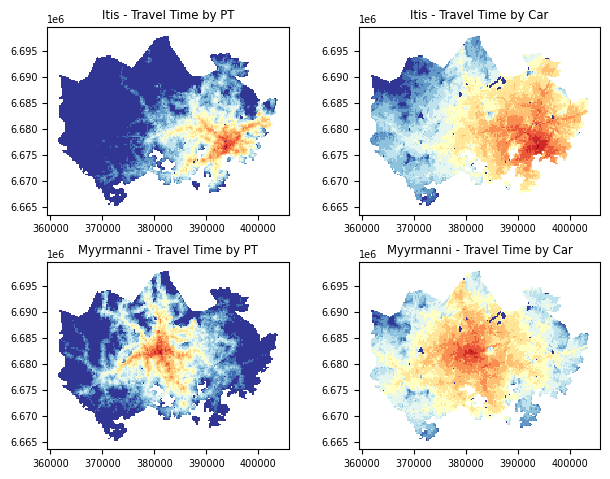

In [150]:
# ADD YOUR OWN CODE HERE
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(2, 2)

for i, shopping_centre in enumerate(("Itis", "Myyrmanni")):
    for j, column in enumerate(("PT", "Car")):
        grid.plot(column=f"{column.lower()}_r_t_cl_{shopping_centre}", ax=ax[i,j], cmap="RdYlBu", linewidth=0)
        ax[i,j].set_title(f'{shopping_centre} - Travel Time by {column}')
        
fig.tight_layout()
plt.savefig(DATA_DIRECTORY / "shopping_centre_accessibility.png")
plt.show()

In [151]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "shopping_centre_accessibility.png").exists()


---

**Finally**, check that you have provided adequate comments in your code.

---

### Reflections

If you want to ask feedback on spesific parts of your code, please leave your comment here


---

### Done!

**Remember to commit the output figure** to your exercise repository!

That’s! Once you have plotted the data and saved the output, you are ready to proceed to *problem 2*.